**Tabla de contenido**

- [Text Classification](#Text-Classification)
    - [The Dataset](#The-Dataset)
        - [A First Look at Hugging Face Datasets](#A-First-Look-at-Hugging-Face-Datasets)
        - [From Datasets to DataFrames](#From-Datasets-to-DataFrames)
        - [Looking at the Class Distribution](#Looking-at-the-Class-Distribution)
        - [How Long Are Our Tweets?](#How-Long-Are-Our-Tweets?)
    - [From Text to Tokens](#From-Text-to-Tokens)
        - [Character Tokenization](#Character-Tokenization)
        - [Word Tokenization](#Word-Tokenization)
        - [Subword Tokenization](#Subword-Tokenization)
        - [Tokenizing the Whole Dataset](#Tokenizing-the-Whole-Dataset)
    - [Training a Text Classifier](#Training-a-Text-Classifier)
        - [Transformers as Feature Extractors](#Transformers-as-Feature-Extractors)
            - [Using pretrained models](#Using-pretrained-models)
                - [Extracting the last hidden states](#Extrayendo-los-ultimos-estados-ocultos)
                - [Creating a feature matrix](#Creating-a-feature-matrix)
                - [Visualizing the training set](#Visualizing-the-training-set)
                - [Training a simple classifier](#Training-a-simple-classifier)
        - [Fine-Tuning Transformers](#Ajuste-Fino-de-Transformadores)
            - [Loading a pretrained model](#Loading-a-pretrained-model)
                - [Defining the performance metrics](#Defining-the-performance-metrics)
                - [Training the model](#Training-the-model)
                - [Error analysis](#Error-analysis)
                - [Saving and sharing the model](#Saving-and-sharing-the-model)
    - [Conclusion](#Conclusion)

# Text Classification

`La clasificación de texto es una de las tareas más comunes en el procesamiento del lenguaje natural (NLP)`; se puede utilizar para una amplia gama de aplicaciones, como `clasificar comentarios` de clientes en categorías o dirigir tickets de soporte según su idioma. ¡Es probable que el filtro de spam de tu programa de correo electrónico esté utilizando clasificación de texto para proteger tu bandeja de entrada de una avalancha de correo no deseado!

Otro tipo común de `clasificación de textos es el análisis de sentimientos`, que (como vimos en el Capítulo 1) tiene como objetivo identificar la polaridad de un texto dado.

Ahora imagina que eres un científico de datos que necesita construir un sistema que pueda identificar automáticamente estados emocionales como "ira" o "alegría" que las personas expresan sobre el producto de tu empresa en Twitter. En este capítulo, abordaremos esta tarea utilizando una variante de BERT llamada `DistilBERT`.

La principal ventaja de este modelo es que `logra un rendimiento comparable al de BERT`, a la vez que es significativamente más pequeño y eficiente. Esto nos permite entrenar un clasificador en unos pocos minutos, y si deseas entrenar un modelo BERT más grande, simplemente puedes cambiar el `checkpoint` del modelo preentrenado. Un `checkpoint` corresponde al `conjunto de pesos que se cargan en una arquitectura de transformador dada`.

## The Dataset

Para construir nuestro detector de emociones utilizaremos un gran conjunto de datos de un artículo que exploró cómo se representan las emociones en los mensajes de Twitter en inglés. A diferencia de la mayoría de los conjuntos de datos de análisis de sentimientos que solo involucran polaridades “positivas” y “negativas”, `este conjunto de datos contiene seis emociones básicas: ira, asco, miedo, alegría, tristeza y sorpresa`.

### A First Look at Hugging Face Datasets

Usaremos Datasets para descargar los datos del Hugging Face Hub. Podemos usar la función list_datasets() para ver qué datasets están disponibles en el Hub:

In [1]:
#pip install ipywidgets
from huggingface_hub import list_datasets

try:
    # Limitar a los primeros 100 datasets 
    datasets = list(list_datasets(limit=10))
    
    total = len(datasets)
    first_5 = [ds.id for ds in datasets[:5]]
    
    print(f"There are {total} datasets currently available on the Hub")
    print(f"The first 10 are: {first_5}")

except Exception as e:
    print(f"An error occurred: {str(e)}")


There are 10 datasets currently available on the Hub
The first 10 are: ['institutional/institutional-books-1.0', 'EssentialAI/essential-web-v1.0', 'fka/awesome-chatgpt-prompts', 'nvidia/Nemotron-Personas', 'lingshu-medical-mllm/ReasonMed']


Vemos que a `cada conjunto de datos se le da un nombre`, así que carguemos el conjunto de datos de `emociones` con la función load_dataset():

In [2]:
# pip install datasets
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

vemos que `es similar a un diccionario de Python, donde cada clave corresponde a una división diferente`. Y podemos usar la sintaxis habitual de diccionario para acceder a una división individual:

In [3]:
train_ds = emotions["train"]
print(train_ds.column_names) # nombre de las columnas
print(train_ds.features) # imprime las clases que hay 
print(train_ds[:5]) # imprime los 5 primeros registros, con sus respectivas clases (label)

['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


Tenga en cuenta que en este caso, `los valores del diccionario son ahora listas en lugar de elementos individuales`. También podemos obtener la columna completa por nombre:

In [4]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### From Datasets to DataFrames

Aunque Datasets proporciona mucha funcionalidad de bajo nivel para segmentar y manipular nuestros datos, a menudo es conveniente convertir un objeto Dataset en un DataFrame de Pandas para que podamos acceder a APIs de alto nivel para la visualización de datos. Para habilitar la conversión, sets proporciona un método set_format() que nos permite cambiar el formato de salida del Dataset. Tenga en cuenta que esto no cambia el formato de datos subyacente (que es una tabla Arrow), y puede cambiar a otro formato más adelante si es necesario:

In [5]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Como puedes ver, `los encabezados de las columnas se han conservado` y las primeras filas coinciden con nuestras vistas anteriores de los datos. `Sin embargo, las etiquetas se representan como enteros`, así que usemos el `método int2str()` de la característica de etiqueta `para crear una nueva columna en nuestro DataFrame con los nombres de etiqueta correspondientes`:

In [6]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Antes de sumergirnos en la construcción de un clasificador, echemos un vistazo más de cerca al conjunto de datos. `Como señala Andrej Karpathy` en su famoso blog `“Una receta para entrenar redes neuronales”`, convertirse en `“uno con los datos”` es un paso esencial para entrenar grandes modelos!

### Looking at the Class Distribution

`Siempre que estés trabajando en problemas de clasificación de texto`, es una buena idea `examinar la distribución de ejemplos en las clases`. Un conjunto de datos con una distribución de clases sesgada podría requerir un tratamiento diferente en términos de pérdida de entrenamiento y métricas de evaluación que uno balanceado.

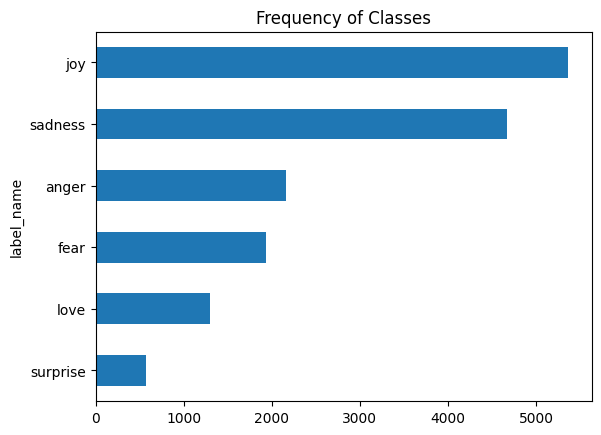

In [7]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

En este caso, podemos ver que `el conjunto de datos está muy desbalanceado`; las clases de alegría y tristeza aparecen con frecuencia, mientras que amor y sorpresa son aproximadamente 5 a 10 veces más raras. Existen varias maneras de lidiar con datos desbalanceados, incluyendo:

- Sobremuestrear aleatoriamente la clase minoritaria.
- Submuestrear aleatoriamente la clase mayoritaria.
- Reunir más datos etiquetados de las clases subrepresentadas.

Si deseas aprender más sobre estas técnicas de muestreo, te recomendamos consultar la biblioteca `Imbalanced-learn`. `¡Solo asegúrate de no aplicar métodos de muestreo antes de crear tus divisiones de entrenamiento/prueba`, o tendrás mucha fuga entre ellas!

Ahora que hemos visto las clases, echemos un vistazo a los tweets en sí.

### How Long Are Our Tweets?

`Los modelos de transformadores tienen una longitud máxima de secuencia de entrada` que se conoce como el tamaño máximo del contexto `(maximum context size)`. Para las aplicaciones que utilizan DistilBERT, el tamaño máximo del contexto es de 512 tokens, lo que equivale a unos pocos párrafos de texto. Como veremos en la siguiente sección, un token es una pieza atómica de texto; por ahora, trataremos un token como una sola palabra. `Podemos obtener una estimación aproximada de las longitudes de los tuits por emoción observando la distribución de palabras por tuit`:

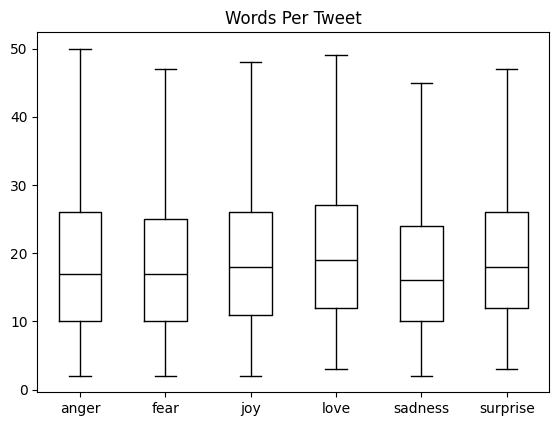

In [8]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

A partir del gráfico, vemos que `para cada emoción, la mayoría de los tweets tienen alrededor de 15 palabras de longitud` y `los tweets más largos están muy por debajo del tamaño máximo de contexto de DistilBERT`. Los textos que son más largos que el tamaño de contexto de un modelo necesitan ser truncados, lo que puede llevar a una pérdida de rendimiento si el texto truncado contiene información crucial; en este caso, parece que eso no será un problema.

`¡Ahora descubramos cómo podemos convertir estos textos en bruto en un formato adecuado para Transformers!` Mientras estamos en eso, `también reiniciemos el formato de salida de nuestro conjunto de datos ya que no necesitamos más el formato de DataFrame`:

In [9]:
emotions.reset_format()

## From Text to Tokens

`Los modelos de transformadores como DistilBERT no pueden recibir cadenas de texto sin procesar como entrada; en su lugar, asumen que el texto ha sido tokenizado y codificado como vectores numéricos`. `La tokenización es el paso de descomponer una cadena en las unidades  utilizadas en el modelo`. Hay varias estrategias de tokenización que se pueden adoptar, y la división óptima de las palabras en subunidades generalmente se aprende del corpus. Antes de mirar el tokenizador utilizado para DistilBERT, consideremos dos casos extremos: `la tokenización a nivel de caracteres` y `la tokenización a nivel de palabras`.


### Character Tokenization

In [10]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


Este es un buen comienzo, pero aún no hemos terminado. `Nuestro modelo espera que cada carácter se convierta en un entero`, un proceso que a veces se llama numerización. Una forma sencilla de hacer esto es codificando cada token único (que son caracteres en este caso) con un entero único:

In [11]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


Esto nos da un mapeo de cada carácter en nuestro vocabulario a un entero único. Ahora podemos usar token2idx para transformar el texto tokenizado en una lista de enteros:

In [12]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Cada token ahora se ha mapeado a un identificador numérico único (de ahí el nombre input_ids). El último paso es convertir input_ids en un tensor 2D de vectores one-hot. Los vectores one-hot se utilizan con frecuencia en el aprendizaje automático para codificar datos categóricos, que pueden ser ordinales o nominales. Por ejemplo, supongamos que queremos codificar los nombres de los personajes de la serie de televisión Transformers. Una forma de hacer esto sería mapear cada nombre a una ID única, de la siguiente manera:

In [13]:
categorical_df = pd.DataFrame(
{"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


El problema con este enfoque es que crea un orden ficticio entre los nombres, y las redes neuronales son muy buenas para aprender este tipo de relaciones. Así que, en lugar de eso, podemos crear una nueva columna para cada categoría y asignar un 1 donde la categoría sea verdadera y un 0 en caso contrario. En Pandas, esto se puede implementar con la función get_dummies() de la siguiente manera:

In [14]:
pd.get_dummies(categorical_df["Name"],dtype=int)

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


Podemos crear las codificaciones one-hot en PyTorch convirtiendo `input_ids` en un tensor y aplicando la función one_hot() de la siguiente manera:

In [15]:
import torch
import torch.nn.functional as F
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

`Para cada uno de los 38 tokens de entrada, ahora tenemos un vector one-hot con 20 dimensiones, ya que nuestro vocabulario consiste en 20 caracteres únicos.`

`Nota`: `Es importante siempre establecer num_classes en la función one_hot()` porque de lo contrario los vectores one-hot pueden terminar siendo más cortos que la longitud del vocabulario (y necesitarán ser rellenados con ceros manualmente). En TensorFlow, la función equivalente es tf.one_hot(), donde el argumento depth cumple el papel de num_classes.

Al examinar el primer vector, podemos verificar que un 1 aparece en la ubicación indicada por input_ids[0]:


In [16]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


A partir de nuestro simple ejemplo, podemos ver que la tokenización a nivel de caracteres ignora cualquier estructura en el texto y trata toda la cadena como un flujo de caracteres. `Aunque esto ayuda a lidiar con errores ortográficos y palabras raras, la principal desventaja es que las estructuras lingüísticas, como las palabras, necesitan ser aprendidas a partir de los datos. Esto requiere un uso significativo de cómputo, memoria y datos`. Por esta razón, `la tokenización de caracteres rara vez se utiliza en la práctica`. En cambio, se preserva alguna estructura del texto durante el proceso de tokenización. La tokenización de palabras es un enfoque simple para lograr esto, así que echemos un vistazo a cómo funciona.

### Word Tokenization

`En lugar de dividir el texto en caracteres, podemos dividirlo en palabras y mapear cada palabra a un número entero`. `Utilizar palabras desde el principio permite al modelo omitir el paso de aprender palabras a partir de caracteres`, y así reduce la complejidad del proceso de entrenamiento.

`Una clase simple de tokenizadores de palabras utiliza el espacio en blanco para tokenizar el texto`. Podemos hacer esto aplicando la función split() de Python directamente en el texto bruto (tal como lo hicimos para medir las longitudes de los tweets):

In [17]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


Desde aquí podemos seguir los mismos pasos que tomamos para el tokenizador de caracteres para mapear cada palabra a un ID. Sin embargo, ya `podemos ver un posible problema con este esquema de tokenización`: `la puntuación no se tiene en cuenta`, por lo que NLP. se trata como un único token. `Dado que las palabras pueden incluir declinaciones, conjugaciones o errores ortográficos`, `¡el tamaño del vocabulario puede crecer fácilmente hasta millones!`

`Nota`: `Algunos tokenizadores de palabras tienen reglas adicionales para la puntuación`. También se puede aplicar el `stemming` o la `lemmatization`, que normaliza las palabras a su raíz (por ejemplo, "grande", "mayor" y "el más grande" se convierten en "grande"), a costa de perder algo de información en el texto.

Tener un vocabulario grande es un problema porque requiere que las redes neuronales tengan un número enorme de parámetros. Naturalmente, queremos evitar ser tan derrochadores con los parámetros de nuestro modelo, ya que los modelos son costosos de entrenar y los modelos más grandes son más difíciles de mantener. 

`Un enfoque común es limitar el vocabulario y descartar palabras raras considerando, por ejemplo, las 100,000 palabras más comunes en el corpus`. Las palabras que no forman parte del vocabulario se clasifican como "desconocidas" y se asignan a un token compartido UNK. Esto significa que perdemos información potencialmente importante en el proceso de tokenización de palabras, ya que el modelo no tiene información sobre las palabras asociadas con UNK.

¿No sería genial si hubiera un compromiso entre la tokenización de caracteres y la tokenización de palabras que preservara toda la información de entrada y parte de la estructura de entrada? Sí lo hay: `la tokenización de subpalabras.`


### Subword Tokenization

`La idea básica detrás de la tokenización de subpalabras es combinar los mejores aspectos de la tokenización por caracteres y palabras.` Por un lado, queremos `dividir palabras raras en unidades más pequeñas` para permitir que `el modelo lidie con palabras complejas y errores ortográficos`. Por otro lado, queremos mantener palabras frecuentes como entidades únicas para que podamos mantener la longitud de nuestras entradas a un tamaño manejable. `La principal característica distintiva de la tokenización de subpalabras` (así como de la tokenización por palabras) `es que se aprende del corpus de preentrenamiento utilizando una mezcla de reglas y algoritmos estadísticos`.

`Hay varios algoritmos de tokenización de subpalabras que se utilizan comúnmente en NLP`, pero comencemos con `WordPiece`, que es utilizado por los tokenizadores de BERT y DistilBERT. La forma más fácil de entender cómo funciona WordPiece es verlo en acción. Transformers proporciona una conveniente clase AutoTokenizer que te permite cargar rápidamente el tokenizador asociado con un modelo preentrenado: solo llamamos a su método from_pretrained(), proporcionando la ID de un modelo en el Hub o una ruta de archivo local. Comencemos cargando el tokenizador para DistilBERT:

In [18]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

La clase `AutoTokenizer` pertenece a un conjunto más amplio de clases "auto", `cuyo trabajo es recuperar automáticamente la configuración del modelo`, `los pesos preentrenados o el vocabulario a partir del nombre del punto de control`. Esto te permite cambiar rápidamente entre modelos, pero si deseas cargar la clase específica manualmente, también puedes hacerlo. Por ejemplo, podríamos haber cargado el tokenizador DistilBERT de la siguiente manera:

In [19]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

Examinemos cómo funciona este tokenizador alimentándolo con nuestro simple ejemplo de “Tokenizing text is a core task of NLP.”

In [20]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Al igual que con la tokenización de caracteres, podemos ver que las palabras han sido mapeadas a enteros únicos en el campo input_ids. Discutiremos el papel del campo attention_mask en la siguiente sección. `Ahora que tenemos los input_ids, podemos convertirlos de nuevo en tokens usando el método convert_ids_to_tokens() del tokenizador:`

In [21]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


`Podemos observar tres cosas aquí`: 
- Primero, se han agregado algunos `tokens especiales` `[CLS]` y `[SEP]` al `inicio` y al `final` de la secuencia. Estos tokens difieren de un modelo a otro, pero `su función principal es indicar el inicio y el final de una secuencia`.

- En segundo lugar, `los tokens han sido convertidos a minúsculas`, lo cual es una característica de este punto de control en particular. Finalmente, podemos ver que `"tokenizing"` y `"NLP"` se han dividido en dos tokens, lo que tiene sentido dado que no son palabras comunes.

`El prefijo ##` en ##izando y ##p `significa que la cadena anterior no es un espacio en blanco`; cualquier token con este prefijo debe fusionarse con el token anterior cuando conviertas los tokens de nuevo a una cadena. La clase AutoTokenizer tiene un método convert_tokens_to_string() para hacer exactamente eso, así que apliquémoslo a nuestros tokens:

In [22]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


La clase AutoTokenizer también tiene varios atributos que proporcionan información sobre el tokenizador. Por ejemplo, podemos inspeccionar el tamaño del vocabulario:

In [23]:
tokenizer.vocab_size

30522

y el tamaño máximo de contexto del modelo correspondiente:

In [24]:
tokenizer.model_max_length

512

Otro atributo interesante que hay que conocer son los nombres de los campos que el modelo espera en su paso hacia adelante:

In [25]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Ahora que tenemos una comprensión básica del proceso de tokenización para una sola cadena, `¡veamos cómo podemos tokenizar todo el conjunto de datos!`

`Nota`: Al usar modelos preentrenados, es muy importante asegurarse de usar el mismo tokenizador con el que se entrenó el modelo. Desde la perspectiva del modelo, cambiar el tokenizador es como barajar el vocabulario. Si todos a tu alrededor comenzaran a intercambiar palabras aleatorias como “casa” por “gato,” también tendrías dificultades para entender lo que está sucediendo.


### Tokenizing the Whole Dataset

`Para tokenizar todo el corpus, usaremos el método map()` de nuestro objeto DatasetDict. Encontraremos este método muchas veces a lo largo de este libro, ya que proporciona una forma conveniente de aplicar una función de procesamiento a cada elemento en un conjunto de datos. Como pronto veremos, `el método map() también se puede usar para crear nuevas filas y columnas`.

Para empezar, lo primero que necesitamos es una función de procesamiento para tokenizar nuestros ejemplos.

Esta función aplica el tokenizador a un lote de ejemplos; `padding=True` rellenará los ejemplos con ceros hasta el tamaño más largo en un lote, y `truncation=True` truncará los ejemplos hasta el tamaño máximo de contexto del modelo. Para ver tokenize() en acción, pasemos un lote de dos ejemplos del conjunto de entrenamiento:

In [26]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Aquí podemos ver el resultado del padding: el primer elemento de input_ids es más corto que el segundo, por lo que se han añadido ceros a ese elemento para que tengan la misma longitud. Estos ceros tienen un token [PAD] correspondiente en el vocabulario, y el conjunto de tokens especiales también incluye los tokens [CLS] y [SEP] que encontramos anteriormente.

`También ten en cuenta que, además de devolver los tweets codificados como input_ids`, `el tokenizador devuelve una lista de arreglos de attention_mask`. Esto se debe a que no queremos que el modelo se confunda por los tokens de relleno adicionales: la máscara de atención permite al modelo ignorar las partes rellenadas de la entrada. La siguiente figura proporciona una explicación visual de cómo se rellenan los input IDs y las máscaras de atención.
![Texto alternativo](images/token.png)

*Para cada lote, las secuencias de entrada se rellenan hasta la longitud máxima de secuencia en el lote; la máscara de atención se utiliza en el modelo para ignorar las áreas rellenadas de los tensores de entrada.*

Una vez que hayamos definido una función de procesamiento, podemos aplicarla a todas las divisiones del corpus en una sola línea de código:

In [27]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Por defecto, el `método map()` opera individualmente en cada ejemplo del corpus, por lo que establecer `batched=True` `codificará los tweets en lotes`. Dado que hemos establecido `batch_size=None`, `nuestra función tokenize() se aplicará a todo el conjunto de datos como un solo lote`. `Esto asegura que los tensores de entrada y las máscaras de atención tengan la misma forma a nivel global`, y podemos ver que esta operación ha añadido nuevas columnas input_ids y attention_mask al conjunto de datos:

In [28]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

Como se discutió en el Capítulo 1, `modelos como DistilBERT están preentrenados para predecir palabras enmascaradas en una secuencia de texto`. `Sin embargo, no podemos usar estos modelos de lenguaje directamente para la clasificación de texto`; `necesitamos modificarlos ligeramente`. Para comprender qué modificaciones son necesarias, echemos un vistazo a la arquitectura de un modelo basado en codificadores como DistilBERT, que se representa en la siguiente figura.
![aquitectura modelo basado en codificadores](images/arquitecturamodelo.png)
*La arquitectura utilizada para la clasificación de secuencias con un transformador basado en un codificador; consiste en el cuerpo preentrenado del modelo combinado con una cabeza de clasificación personalizada.*

Primero, el texto se tokeniza y se representa como vectores one-hot llamados codificaciones de tokens. El tamaño del vocabulario del tokenizador determina la dimensión de las codificaciones de tokens, y generalmente consiste en 20k a 200k tokens únicos. A continuación, estas codificaciones de tokens se convierten en token embeddings, que son vectores que viven en un espacio de menor dimensión. Luego, los token embeddings se pasan a través de las capas del bloque del codificador para generar un `hidden state` para cada token de entrada. `Para el objetivo de preentrenamiento de modelado de lenguaje`, cada `hidden state` se alimenta a una capa que predicew los `masked input tokens`. Para la tarea de clasificación, reemplazamos la capa de modelado de lenguaje por una capa de clasificación.

`Nota`: En la práctica, PyTorch omite el paso de crear vectores one-hot para las codificaciones de tokens, porque multiplicar una matriz con un vector one-hot es lo mismo que seleccionar una columna de la matriz. Esto se puede hacer directamente obteniendo la columna con el ID del token de la matriz. 

`Tenemos dos opciones para entrenar un modelo así en nuestro conjunto de datos de Twitter:`
- **Feature extraction**: Utilizamos los estados ocultos (hidden states) como características y simplemente entrenamos un clasificador sobre ellos, sin modificar el modelo preentrenado.
- **Fine-tuning**: Entrenamos todo el modelo de extremo a extremo, lo que también actualiza los parámetros del modelo preentrenado.

`En las siguientes secciones exploramos ambas opciones para DistilBERT y examinamos sus compensaciones.`

### Transformers as Feature Extractors

`Usar un transformador como extractor de características es bastante simple`. Como se muestra en la siguiente Figura, congelamos los pesos del cuerpo durante el entrenamiento y usamos los estados ocultos como características para el clasificador. `La ventaja de este enfoque es que podemos entrenar rápidamente un modelo pequeño o superficial`. Tal modelo podría ser una capa de clasificación neuronal o un método que no dependa de gradientes, como un bosque aleatorio. `Este método es especialmente conveniente si las GPU no están disponibles,` ya que los estados ocultos solo necesitan ser precomputados una vez.

![features stractor](images/featurestractor.png)
*En el enfoque basado en características, el modelo DistilBERT está congelado y solo proporciona características para un clasificador.*

#### Using pretrained models

Usaremos otra clase de auto conveniente de Transformers llamada AutoModel. Similar a la clase AutoTokenizer, AutoModel tiene un método from_pretrained() para cargar los pesos de un modelo preentrenado. Utilicemos este método para cargar el echeckpoint  de DistilBERT:


In [29]:
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

La `clase AutoModel` convierte las codificaciones de tokens en embeddings y luego las alimenta a través de la pila del codificador para devolver los estados ocultos (hidden states). Echemos un vistazo a cómo podemos extraer estos estados de nuestro corpus.

##### Extrayendo los ultimos estados ocultos


Para calentar, recuperemos los últimos estados ocultos para una única cadena. Lo primero que necesitamos hacer es codificar la cadena y convertir los tokens en tensores de PyTorch. Esto se puede hacer proporcionando el argumento `return_tensors="pt"` al tokenizador de la siguiente manera:

In [30]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


Como podemos ver, `el tensor resultante tiene la forma [tamaño_lote, n_tokens]`. Ahora que tenemos las codificaciones como un tensor, el paso final es colocarlas en el mismo dispositivo que el modelo y pasar las entradas de la siguiente manera:

In [31]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Aquí hemos utilizado el gestor de contexto `torch.no_grad()` para desactivar el cálculo automático del gradiente. Esto es útil para la inferencia ya que reduce la huella de memoria de los cálculos. Dependiendo de la configuración del modelo, la salida puede contener varios objetos, como los estados ocultos, pérdidas o atenciones, organizados en una clase similar a un namedtuple en Python. En nuestro ejemplo, la salida del modelo es una instancia de `BaseModelOutput`, y podemos acceder a sus atributos por nombre. El modelo actual devuelve solo un atributo, que es el último estado oculto, así que examinemos su forma:

In [32]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Mirando el `hidden state tensor`, vemos que tiene la forma `[tamaño_lote, n_tokens, dimensión_oculta]`. En otras palabras, se devuelve un vector de 768 dimensiones para cada uno de los 6 tokens de entrada. `Para tareas de clasificación`, `es una práctica común utilizar simplemente el hidden state asociado con el token [CLS] como la característica de entrada`. Dado que este token aparece al inicio de cada secuencia, podemos extraerlo indexando en `outputs.last_hidden_state` de la siguiente manera:


In [33]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Ahora sabemos cómo obtener el último estado oculto para una sola cadena; hagamos lo mismo para todo el conjunto de datos creando una nueva columna hidden_state que almacene todos estos vectores. Como hicimos con el tokenizador, usaremos el método map() de DatasetDict para extraer todos los estados ocultos de una vez. Lo primero que necesitamos hacer es envolver los pasos anteriores en una función de procesamiento:

In [34]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


La única diferencia entre esta función y nuestra lógica anterior es el paso final donde colocamos el estado oculto final (ast_hidden_state) de nuevo en la CPU como un arreglo de NumPy. `El método map() requiere que la función de procesamiento devuelva objetos de Python o NumPy cuando estamos usando entradas por lotes.`

`Dado que nuestro modelo espera tensores como entradas`, lo siguiente que debemos hacer es `convertir las columnas input_ids y attention_mask` al formato 'torch', de la siguiente manera:

In [35]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Podemos proceder a extraer los hidden states en todos los segmentos de una vez:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Observe que en este caso `no establecimos batch_size=None`, lo que significa que `se usa el batch_size=1000` por defecto. Como era de esperar, al aplicar la función extract_hidden_states() se ha agregado una nueva columna hidden_state a nuestro conjunto de datos:

In [36]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Ahora que tenemos los estados ocultos asociados con cada tweet, el siguiente paso es `entrenar un clasificador con ellos`. Para hacer eso, `necesitaremos una matriz de características`—veamos.

##### Creating a feature matrix

`El conjunto de datos preprocesado ahora contiene toda la información que necesitamos para entrenar un clasificador`. Usaremos los estados ocultos como características de entrada y las etiquetas como objetivos. Podemos crear fácilmente los arrays correspondientes en el conocido formato de Scikit-learn de la siguiente manera:

In [37]:
import numpy as np
X_train = np.asarray(emotions_hidden["train"]["hidden_state"])
X_valid = np.asarray(emotions_hidden["validation"]["hidden_state"])
y_train = np.asarray(emotions_hidden["train"]["label"])
y_valid = np.asarray(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

`Antes de entrenar un modelo sobre los estados ocultos (hidden state)`, es una buena práctica realizar una verificación rápida para asegurarnos de que ofrecen una representación útil de las emociones que queremos clasificar. En la siguiente sección, veremos cómo visualizar las características que proporciona una forma rápida de lograrlo.

##### Visualizing the training set

`Dado que visualizar los estados ocultos en 768 dimensiones es complicado`, utilizaremos el potente algoritmo `UMAP` para proyectar los vectores a 2D. Dado que UMAP funciona mejor cuando las características están escaladas para estar en el intervalo [0,1], primero aplicaremos un MinMaxScaler y luego utilizaremos la implementación de UMAP de la biblioteca umap-learn para reducir los estados ocultos:

In [38]:
#pip install umap-learn
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/home/luisgarcia/anaconda3/envs/NLP/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.066225,3.310304,0
1,-3.065524,4.123321,0
2,4.886285,6.651852,3
3,-2.337347,6.136347,2
4,-3.355906,6.112323,3


El resultado es un arreglo con el mismo número de muestras de entrenamiento, pero con solo 2 características en lugar de las 768 con las que comenzamos. Investiguemos los datos comprimidos un poco más y tracemos la densidad de puntos para cada categoría por separado:

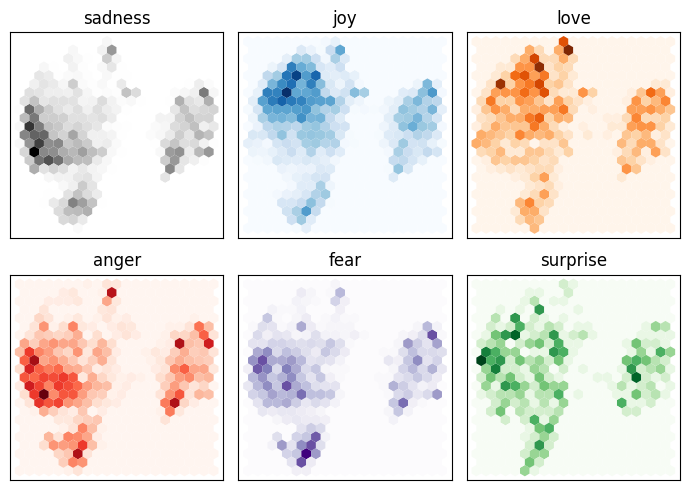

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

`Nota:` Estas son solo proyecciones en un espacio de menor dimensión. Solo porque algunas categorías se superpongan no significa que no sean separables en el espacio original. Por el contrario, si son separables en el espacio proyectado, serán separables en el espacio original.

A partir de este gráfico, podemos ver algunos patrones claros: los sentimientos negativos como `sadness`, `anger` y `fear` ocupan regiones similares con distribuciones ligeramente diferentes. Por otro lado, `joy` y `love` están bien separados de las emociones negativas y también comparten un espacio similar. Finalmente, `surprise` está dispersa por toda partes. Aunque podríamos haber esperado cierta separación, esto no está garantizado, ya que el modelo no fue entrenado para diferenciar entre estas emociones. Solo las aprendió implícitamente al adivinar las palabras enmascaradas en los textos.

Ahora que hemos obtenido información sobre las características de nuestro conjunto de datos, ¡finalmente entrenemos un modelo con él!


##### Training a simple classifier

Hemos visto que los estados ocultos (hidden state) son algo diferentes entre las emociones, aunque para varias de ellas no hay un límite obvio. Usemos estos estados ocultos para entrenar un modelo de regresión logística con Scikit-learn. Entrenar un modelo tan simple es rápido y no requiere una GPU:

In [40]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6345

Al observar la precisión, podría parecer que nuestro modelo es solo un poco mejor que el azar, pero dado que estamos tratando con un conjunto de datos multicategoría desbalanceado, en realidad es significativamente mejor. Podemos examinar si nuestro modelo es efectivo comparándolo con una línea base simple. `En Scikit-learn hay un DummyClassifier` que se puede usar para `construir un clasificador con heurísticas simples`, como elegir siempre la clase mayoritaria o siempre seleccionar una clase al azar. En este caso, la heurística de mejor rendimiento es elegir siempre la clase más frecuente, lo que produce una precisión de alrededor del 35%.

In [41]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

Así que, nuestro clasificador simple con embeddings de DistilBERT es significativamente mejor que nuestra línea base. Podemos investigar más a fondo el rendimiento del modelo observando la matriz de confusión del clasificador, que nos muestra la relación entre las etiquetas verdaderas y las predicciones:

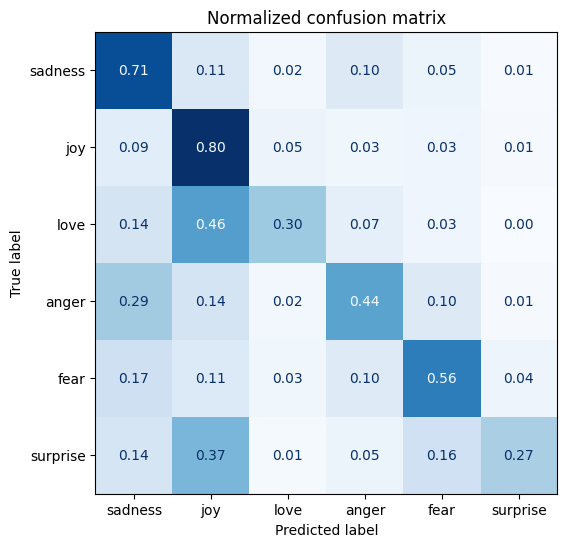

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Podemos ver que `anger` y `fear` a menudo se confunden con `sadness`, lo cual coincide con la observación que hicimos al visualizar los embeddings. Además, `love` y `surprise` a menudo se confunden con la `joi`.

En la próxima sección exploraremos el enfoque de ajuste fino, que conduce a un rendimiento de clasificación superior. Sin embargo, es importante notar que hacer esto requiere más recursos computacionales, como GPU, que podrían no estar disponibles en su organización. En casos como estos, un enfoque basado en características puede ser un buen compromiso entre hacer aprendizaje automático tradicional y aprendizaje profundo.

### Ajuste Fino de Transformadores

Ahora exploremos qué se necesita para ajustar un transformador end-to-end. Con el enfoque de ajuste fino, no usamos los estados ocultos (hidden state) como características fijas, sino que los entrenamos como se muestra en la siguiente Figura.
![Ajustefino](images/ajustefino.png)
Esto requiere que la cabeza de clasificación sea diferenciable, razón por la cual este método generalmente utiliza una red neuronal para la clasificación.

`Entrenar los estados ocultos` (hidden state) que sirven como entradas para el modelo de clasificación `nos ayudará a evitar el problema de trabajar con datos que pueden no ser adecuados para la tarea de clasificación`. En cambio, los `estados ocultos (hidden state) iniciales` se adaptan durante el entrenamiento para disminuir la pérdida del modelo y así aumentar su rendimiento.

#### Loading a pretrained model

`Lo primero que necesitamos es un modelo DistilBERT previamente entrenado` como el que usamos en el enfoque basado en características. La única ligera modificación es que usamos el `modelo AutoModelFor SequenceClassification` en lugar de AutoModel. La diferencia es que el `modelo AutoModelForSequenceClassification tiene un encabezado de clasificación encima de las salidas del modelo previamente entrenadas`, que se entrena fácilmente con el modelo base. Solo necesitamos especificar cuántas etiquetas tiene que predecir el modelo (seis en nuestro caso).

In [43]:
from transformers import AutoModelForSequenceClassification
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Verás una advertencia de que algunas partes del modelo están inicializadas aleatoriamente. Esto es normal ya que la cabeza de clasificación aún no ha sido entrenada. El siguiente paso es definir las métricas que utilizaremos para evaluar el rendimiento de nuestro modelo durante el ajuste fino.

##### Defining the performance metrics

Para monitorear las métricas durante el entrenamiento, necesitamos definir una función compute_metrics() para el Entrenador. Esta función recibe un objeto EvalPrediction (que es una tupla con nombre con atributos de predicciones y label_ids) y debe devolver un diccionario que mapea el nombre de cada métrica a su valor. Para nuestra aplicación, calcularemos la puntuación F1 y la precisión del modelo de la siguiente manera:


In [44]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Con el conjunto de datos y las métricas listas, solo tenemos dos cosas finales que atender antes de definir la Trainer class:
1. Inicia sesión en nuestra cuenta en el Hugging Face Hub. Esto nos permitirá subir nuestro modelo afinado a nuestra cuenta en el Hub y compartirlo con la comunidad.
2. Define todos los hiperparámetros para la ejecución del entrenamiento.

Abordaremos estos pasos en la próxima sección.

##### Training the model

Si estás ejecutando este código en un cuaderno de Jupyter, puedes iniciar sesión en el Hub con la siguiente función de ayuda:

Esto mostrará un widget en el que puedes ingresar tu nombre de usuario y contraseña, o un token de acceso con privilegios de escritura. Puedes encontrar detalles sobre cómo crear tokens de acceso en la documentación de Hub. 

In [46]:
from huggingface_hub import notebook_login
notebook_login()

Para definir los parámetros de entrenamiento, utilizamos la clase `TrainingArguments`. Esta clase almacena mucha información y te ofrece un control detallado sobre el entrenamiento y la evaluación. `El argumento más importante a especificar es output_dir`, que es donde se almacenan todos los artefactos del entrenamiento. Aquí hay un ejemplo de TrainingArguments en todo su esplendor:

In [47]:
#pip install transformers[torch]
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")


Aquí también establecemos el tamaño del lote, la tasa de aprendizaje y el número de épocas, y especificamos cargar el mejor modelo al final de la ejecución del entrenamiento. Con este ingrediente final, podemos instanciar y ajustar nuestro modelo con el Trainer:

In [48]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/tmp/ipykernel_82212/2697864529.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.788400,0.293407,0.909500,0.908522
2,0.241300,0.207929,0.926000,0.925990


Al observar los registros, podemos ver que nuestro modelo tiene una puntuación F1 en el conjunto de validación de alrededor del 92%—¡esta es una mejora significativa en comparación con el enfoque basado en características!

`Podemos echar un vistazo más detallado a las métricas de entrenamiento calculando la matriz de confusión`. Para visualizar la matriz de confusión, primero necesitamos obtener las predicciones en el conjunto de validación. El método predict() de la clase Trainer devuelve varios objetos útiles que podemos utilizar para la evaluación:


In [49]:
preds_output = trainer.predict(emotions_encoded["validation"])

La salida del método predict() es un objeto PredictionOutput que contiene arreglos de predicciones y label_ids, junto con las métricas que pasamos al entrenador. Por ejemplo, las métricas en el conjunto de validación se pueden acceder de la siguiente manera:

In [50]:
preds_output.metrics

{'test_loss': 0.20792925357818604,
 'test_accuracy': 0.926,
 'test_f1': 0.9259895651480966,
 'test_runtime': 3.3899,
 'test_samples_per_second': 589.979,
 'test_steps_per_second': 9.44}

También contiene las predicciones en bruto para cada clase. Podemos decodificar las predicciones de manera codiciosa usando np.argmax(). Esto produce las etiquetas predichas y tiene el mismo formato que las etiquetas devueltas por los modelos de Scikit-learn en el enfoque basado en características:

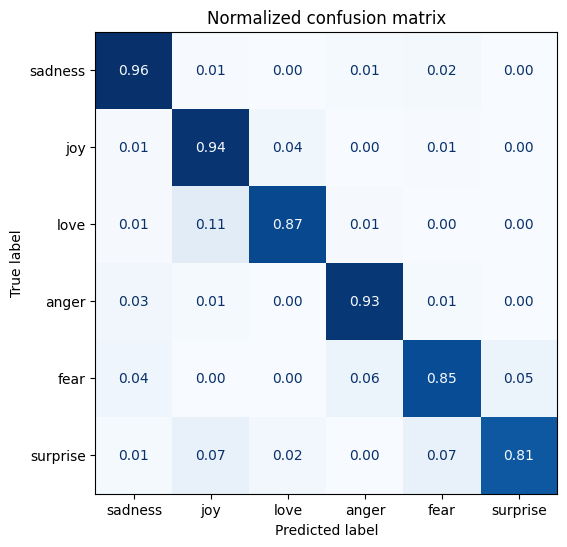

In [51]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

Esto está mucho más cerca de la matriz de confusión diagonal ideal. La categoría de amor a menudo todavía se confunde con la de alegría, lo que parece natural. La sorpresa también se confunde frecuentemente con la alegría o se confunde con el miedo. En general, el rendimiento del modelo parece bastante bueno, pero antes de dar por terminado el día, profundicemos un poco más en los tipos de errores que es probable que cometa nuestro modelo.

##### Error analysis

Antes de continuar, deberíamos investigar un poco más las predicciones de nuestro modelo. Una técnica simple pero poderosa es ordenar las muestras de validación por la pérdida del modelo. Cuando pasamos la etiqueta durante la pasada hacia adelante, la pérdida se calcula automáticamente y se devuelve. Aquí hay una función que devuelve la pérdida junto con la etiqueta predicha:

In [52]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),reduction="none")
        # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

Usando el método map() una vez más, podemos aplicar esta función para obtener las pérdidas para todas las muestras:

In [53]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Finalmente, creamos un DataFrame con los textos, las pérdidas y las etiquetas predichas/reales:

In [54]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

Ahora podemos clasificar fácilmente emotions_encoded por las pérdidas en orden ascendente o descendente. El objetivo de este ejercicio es detectar uno de los siguientes:

- `Etiquetas incorrectas (Wrong labels):` Cada proceso que añade etiquetas a los datos puede ser defectuoso. Los anotadores pueden cometer errores o estar en desacuerdo, mientras que las etiquetas que se inferen de otras características pueden ser incorrectas. Si fuera fácil anotar automáticamente los datos, entonces no necesitaríamos un modelo para hacerlo. Por lo tanto, es normal que haya algunos ejemplos etiquetados incorrectamente. Con este enfoque, podemos encontrar y corregirlos rápidamente.
- `Particularidades del conjunto de datos (Quirks of the dataset)`: Los conjuntos de datos en el mundo real siempre son un poco desordenados. Al trabajar con texto, los caracteres especiales o cadenas en las entradas pueden tener un gran impacto en las predicciones del modelo. Inspeccionar las predicciones más débiles del modelo puede ayudar a identificar tales características, y limpiar los datos o inyectar ejemplos similares puede hacer que el modelo sea más robusto.

Primero veamos las muestras de datos con las mayores pérdidas:


In [55]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.309012
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.157819
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.142580
465,i would eventually go in to these stores but i...,joy,fear,5.073149
1274,i am going to several holiday parties and i ca...,joy,sadness,5.004437
1111,im lazy my characters fall into categories of ...,joy,fear,5.000310
765,i feel super awkward and out of place right now,joy,sadness,4.699862
1801,i feel that he was being overshadowed by the s...,love,sadness,4.676537
1950,i as representative of everything thats wrong ...,surprise,sadness,4.442641
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.290716


Podemos ver claramente que `el modelo predijo incorrectamente algunas de las etiquetas`. Por otro lado, parece que hay bastantes ejemplos sin una clase clara, que podrían estar mal etiquetados o requerir una nueva clase por completo. En particular, la alegría parece estar mal etiquetada varias veces. `Con esta información podemos refinar el conjunto de datos`, lo que a menudo puede conducir a una mejora de rendimiento tan grande (o más) como tener más datos o modelos más grandes.

Al observar las muestras con las pérdidas más bajas, vemos que el modelo parece estar más confiado al predecir la clase de tristeza. `Los modelos de aprendizaje profundo son excepcionalmente buenos en encontrar y explotar atajos para llegar a una predicción`. Por esta razón, también vale la pena invertir tiempo en examinar los ejemplos sobre los que el modelo tiene más confianza, para que podamos estar seguros de que el modelo no explota inapropiadamente ciertas características del texto. Entonces, también veamos las predicciones con la pérdida más pequeña:

In [56]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017932
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017990
1873,i feel practically virtuous this month i have ...,joy,joy,0.018036
69,i have no extra money im worried all of the ti...,sadness,sadness,0.018046
1310,i feel like an ungrateful asshole,sadness,sadness,0.018135
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.018226
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.018233
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.018239
578,i got to christmas feeling positive about the ...,joy,joy,0.018250
277,i just feel like if i can just make it through...,joy,joy,0.018362


Ahora sabemos que la alegría a veces está mal etiquetada y que el modelo tiene más confianza en predecir la etiqueta de tristeza. Con esta información, podemos hacer mejoras específicas en nuestro conjunto de datos y también vigilar la clase sobre la que el modelo parece estar muy seguro.

El último paso antes de servir el modelo entrenado es guardarlo para un uso posterior. Transformers nos permite hacer esto en unos pocos pasos, que te mostraremos en la siguiente sección.

##### Saving and sharing the model

La comunidad de NLP se beneficia enormemente de compartir modelos preentrenados y afinados, y todos pueden compartir sus modelos con otros a través del Hugging Face Hub. Cualquier modelo generado por la comunidad se puede descargar del Hub de la misma manera que descargamos el modelo DistilBERT. Con la API Trainer, guardar y compartir un modelo es sencillo:

In [57]:
trainer.push_to_hub(commit_message="Training completed!")

Uploading...:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/luiscxz/distilbert-base-uncased-finetuned-emotion/commit/95b2a23ac02a2b74ab11dbb0857cee1c61bcad62', commit_message='Training completed!', commit_description='', oid='95b2a23ac02a2b74ab11dbb0857cee1c61bcad62', pr_url=None, repo_url=RepoUrl('https://huggingface.co/luiscxz/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='luiscxz/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

También podemos usar el modelo ajustado para hacer predicciones sobre nuevos tweets. Dado que hemos subido nuestro modelo al Hub, ahora podemos usarlo con la función pipeline(), así como hicimos en el Capítulo 1. Primero, carguemos la pipeline:

In [58]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Entonces, probemos el pipeline con un tweet de muestra:


In [59]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/home/luisgarcia/anaconda3/envs/NLP/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Finalmente, podemos trazar la probabilidad de cada clase en un gráfico de barras. Claramente, el modelo estima que la clase más probable es la alegría, lo cual parece razonable dado el tuit:

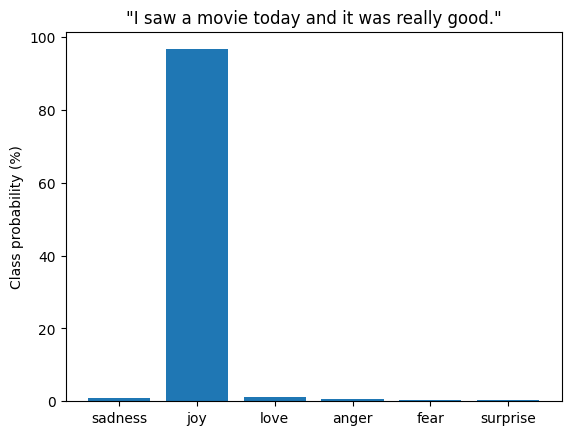

In [60]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion

¡Felicidades, ahora sabes cómo entrenar un modelo transformer para clasificar las emociones en los tweets! Hemos visto dos enfoques complementarios basados en características y en ajuste fino, y hemos investigado sus fortalezas y debilidades.

Sin embargo, este es solo el primer paso en la creación de una aplicación del mundo real con modelos transformer, y aún tenemos mucho camino por recorrer. Aquí hay una lista de desafíos que es probable que enfrentes en tu viaje de NLP:

- `¡Mi jefe quiere que mi modelo esté en producción desde ayer!`: En la mayoría de las aplicaciones, tu modelo no solo se queda en un lugar acumulando polvo, ¡quieres asegurarte de que está sirviendo predicciones! Cuando un modelo es enviado al Hub, se crea automáticamente un punto de finalización de inferencia que se puede llamar con solicitudes HTTP. Te recomendamos revisar la documentación de la API de Inferencia si deseas aprender más.
- `¡Mis usuarios quieren predicciones más rápidas!`:Ya hemos visto un enfoque para este problema: usar DistilBERT. En el Capítulo 8 profundizaremos en la destilación de conocimiento (el proceso por el cual se creó DistilBERT), junto con otros trucos para acelerar tus modelos de transformador.
- `¿Puede su modelo también hacer x?`: Como hemos aludido en este capítulo, los transformadores son extremadamente versátiles. En el resto del libro exploraremos una variedad de tareas, como responder preguntas y reconocer entidades nombradas, todas usando la misma arquitectura.
- `¡Ninguno de mis textos está en inglés!`: Resulta que los transformers también vienen en una variedad multilingüe, y los usaremos en el capítulo 4 para abordar varios idiomas a la vez.
- `¡No tengo etiquetas!`: Si hay muy pocos datos etiquetados disponibles, es posible que el ajuste fino no sea una opción. En el capítulo 9, exploraremos algunas técnicas para lidiar con esta situación.

`Ahora que hemos visto lo que implica entrenar y compartir un transformador, en el próximo capítulo exploraremos la implementación de nuestro propio modelo de transformador desde cero.`
